In [1]:
import os
import sys
import numpy as np
import pandas as pd
import gensim
import keras as ks
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model 
from keras.layers import Dense, Flatten
from keras.engine.topology import Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.initializers import Initializer
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
print(ks.__version__)
print(tf.__version__)

2.0.3
1.1.0


# 1.0 Data Preperation and Understanding

In [3]:
HOME_DIR = "/home/avkash/toolkit/github/answerbot/"
review_file = "5star_reviews_2cols.csv"

In [4]:
pr = pd.read_csv(HOME_DIR + review_file)

In [5]:
pr.columns

Index([u'text', u'stars'], dtype='object')

In [6]:
pr.shape

(4153149, 2)

In [7]:
pr.stars.unique()

array([ 5.,  4.,  1.,  3.,  2.])

In [8]:
pr['stars'].value_counts()

5.0    1704199
4.0    1032654
1.0     540377
3.0     517369
2.0     358550
Name: stars, dtype: int64

In [11]:
# Working on 1% of the data
pr = pr.sample(frac=0.1)

In [12]:
pr.shape

(41532, 2)

In [13]:
pr['stars'].value_counts()

5.0    17018
4.0    10411
1.0     5315
3.0     5148
2.0     3640
Name: stars, dtype: int64

In [14]:
reviews_raw = pr['text'].tolist()
labels = pr['stars'].tolist()

In [15]:
labels_items = pr['stars'].unique()
print(len(labels_items))
print(labels_items)

5
[ 5.  4.  3.  1.  2.]


In [16]:
# Converting label_index
labels_index = {}
for x in labels_items:
    labels_index[x] = x
print labels_index
print len(labels_index)

{1.0: 1.0, 2.0: 2.0, 3.0: 3.0, 4.0: 4.0, 5.0: 5.0}
5


# 2.0 - Creating collection of words in all sentences
## - Removing bad words

In [17]:
# Import the stop word list
from nltk.corpus import stopwords 
# Test if we do have stopwords
print stopwords.words("english") 

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [18]:
# Cleaning function
from bs4 import BeautifulSoup 
import re
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = raw_review #BeautifulSoup(raw_review).get_text() 
    # 1. Making sure string is string
    review_text = str(review_text)

    # 2. Remove non-letters
    if len(review_text) > 0:
        letters_only = re.sub("[^a-zA-Z0-9]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [20]:
# Initialize an empty list to hold the clean reviews
reviews_len = len(reviews_raw)
reviews = []
print "Total Reviews: ", reviews_len
# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in xrange( 0, reviews_len ):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    reviews.append( review_to_words( reviews_raw[i] ) )
    if ( i%10000 == 0):
        print "Processed... ", i

Total Reviews:  41532
Processed...  0
Processed...  10000
Processed...  20000
Processed...  30000
Processed...  40000


In [29]:
# Displaying random review text 
from random import randint
i_x = randint(0,len(reviews))
print("Index %s" % i_x)
print(reviews_raw[i_x])
print(labels[i_x])

Index 9277
Love getting my haircut here!  It's only $25 for a women's haircut.  I'm pretty picky about how much my hair is layered and I've never had a problem here.  Make sure to call in to schedule your appointment ahead of time during the school year because she's usually booked two days in advance.
5.0


# 3.0 Tokenization and Uniform data creation

In [30]:
# Configuration 
# Total number of words we are going to process
MAX_NB_WORDS = 50000

In [31]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS) # num_words replaced with nb_words
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/home/avkash/.local/lib/python2.7/site-packages/keras/preprocessing/text.py:89: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 60914 unique tokens.


In [32]:
# str(word_index) - All words
# word_index.items()[10] - Get Specific index
word_index.items()

[('fawn', 25958),
 ('gai', 9398),
 ('saimin', 20320),
 ('mustachio', 33915),
 ('huileux', 33917),
 ('kalaches', 33918),
 ('accueille', 33919),
 ('woods', 5840),
 ('clotted', 25959),
 ('spiders', 21658),
 ('hanging', 1605),
 ('woody', 12136),
 ('northsight', 33920),
 ('comically', 18927),
 ('natasza', 33921),
 ('sevens', 18928),
 ('canes', 9730),
 ('hermans', 33922),
 ('isaid', 33923),
 ('chatter', 9961),
 ('adviced', 33924),
 ('scold', 18929),
 ('originality', 17088),
 ('refunding', 15659),
 ('rickman', 33925),
 ('canel', 33926),
 ('bocks', 25960),
 ('breeders', 25961),
 ('hahahah', 33927),
 ('naturopathic', 25962),
 ('stipulate', 33928),
 ('pigment', 33929),
 ('fattiness', 14532),
 ('capoeira', 18930),
 ('touristes', 33930),
 ('foul', 9890),
 ('quinona', 58290),
 ('bringing', 1658),
 ('bagoli', 33931),
 ('kasperski', 33932),
 ('tcby', 21660),
 ('revelers', 33933),
 ('caramels', 22989),
 ('spacy', 25965),
 ('grueling', 17090),
 ('broiler', 13593),
 ('fous', 33934),
 ('wooden', 3253),
 

In [34]:
word_index.keys()

['fawn',
 'gai',
 'saimin',
 'mustachio',
 'huileux',
 'kalaches',
 'accueille',
 'woods',
 'clotted',
 'spiders',
 'hanging',
 'woody',
 'northsight',
 'comically',
 'natasza',
 'sevens',
 'canes',
 'hermans',
 'isaid',
 'chatter',
 'adviced',
 'scold',
 'originality',
 'refunding',
 'rickman',
 'canel',
 'bocks',
 'breeders',
 'hahahah',
 'naturopathic',
 'stipulate',
 'pigment',
 'fattiness',
 'capoeira',
 'touristes',
 'foul',
 'quinona',
 'bringing',
 'bagoli',
 'kasperski',
 'tcby',
 'revelers',
 'caramels',
 'spacy',
 'grueling',
 'broiler',
 'fous',
 'wooden',
 'biggggg',
 'condessa',
 'wednesday',
 'unblurred',
 'broiled',
 'crotch',
 'stereotypical',
 'caramelo',
 'bbqs',
 'popularit',
 'expeirence',
 'gaskets',
 'francesco',
 'scrapes',
 'scraper',
 '270',
 'miniatures',
 '272',
 '273',
 'alltaeglichen',
 'mortgages',
 'gorman',
 'sustaining',
 'scraped',
 'snuggled',
 'moctail',
 'errors',
 'deferred',
 'anbauten',
 'cooking',
 'huong',
 'opportunists',
 'familles',
 'bervo

# 3.1 Creating Word Cloud

(-0.5, 1439.5, 1079.5, -0.5)

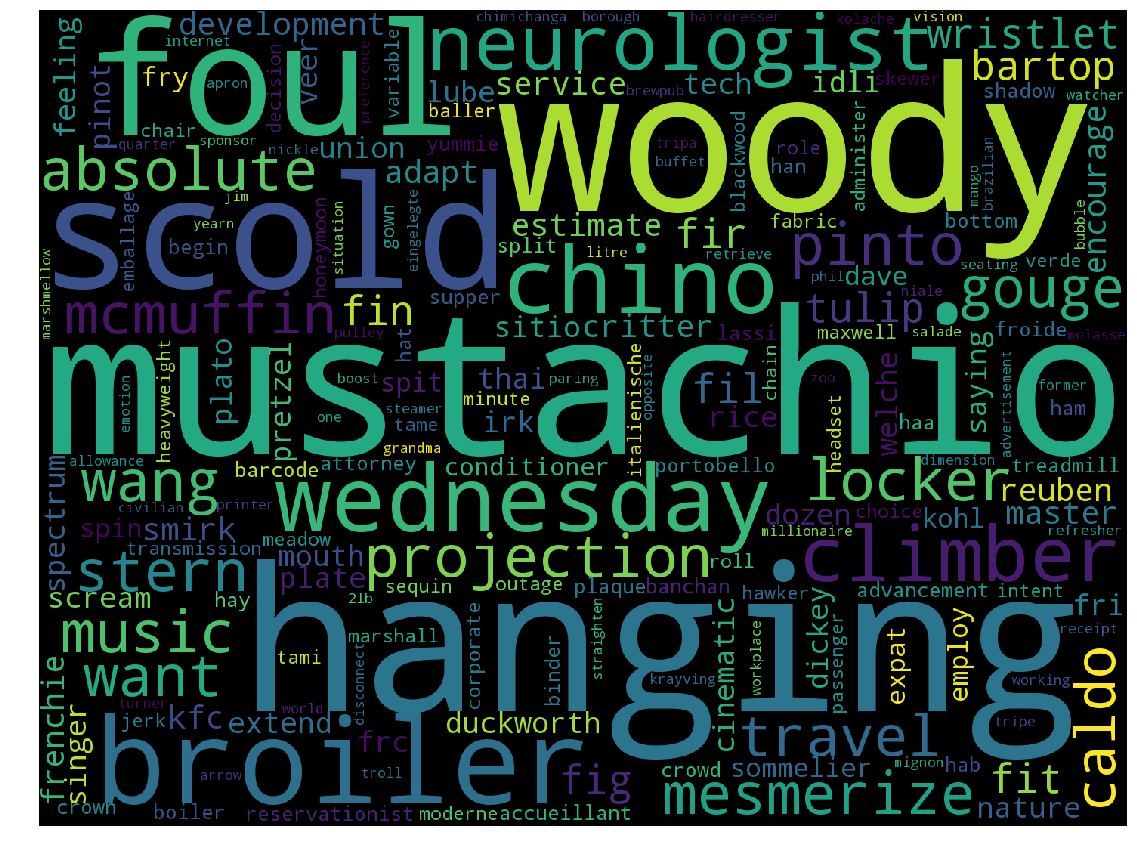

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

cloud = WordCloud(width=1440, height=1080).generate(" ".join(word_index.keys()))
                                                   
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# 3.2 Creating uniform dataset
Note: 
-     We have len(reviews) 
-     We found len(word_index)  = 59480   -> Unique Tokens in our collection 

In [47]:
# Sequence is list here
print(len(reviews))
print(len(sequences))
print(sequences[5])   # 1, 5, 100

41532
41532
[10, 1161, 9210, 929, 478, 129, 194, 815, 147, 1896, 4, 1896, 13, 3169, 4973, 2108, 730, 4, 63, 1069, 164, 5865, 7, 975, 1, 211, 424, 113, 147, 1767, 186, 27, 1767, 1, 75, 283, 99, 1, 283, 112, 1767, 1, 5979, 295, 1, 516, 244, 2, 345, 12, 1, 37, 147, 150, 86, 35, 12, 1, 37, 1, 79, 462, 59, 78, 55, 147, 2, 9936, 153, 184, 24, 9520, 18, 45, 7779, 1574, 153, 58, 1896, 562, 305, 153, 105, 48, 70, 1065, 160, 72, 435, 1400, 306, 1, 69, 26, 130, 85, 514, 811, 367, 730, 88, 5, 768, 698, 900, 768, 1776, 300, 11, 27, 284, 150, 435, 3, 1185, 992, 104, 744, 712, 2067, 1642, 18, 1045, 3836, 7, 300, 225, 900, 1, 156, 266, 621, 20816, 2032, 382, 427, 843]


In [39]:
# Configuration
MAX_SEQUENCE_LENGTH = 1000 # DO not exceed it over 1000, which is high limit

In [40]:
# Converting sequence to vector of same width/depth
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

('Shape of data tensor:', (41532, 1000))


In [49]:
# We can see the any item from the data as below:
print(data[5,])  # 1,5,100

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [50]:
new_labels = to_categorical(np.asarray(labels))
print('Shape of label tensor:', new_labels.shape) ## All the stars are label now

('Shape of label tensor:', (41532, 6))


In [51]:
# Verifying Labels for distribtion
print(new_labels[0,])
print(new_labels[2,])

[ 0.  0.  0.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  1.]


# At this point we have data set
- Data -> 41532 Sentences of 1000
- Labels > 41532 labels of 6

# 4.0 Splitting dataset to traning and validation

In [52]:
# Configuration
VALIDATION_SPLIT = 0.2 # 80/20 split

In [53]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labelsX = new_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labelsX[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labelsX[-num_validation_samples:]

In [54]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(33226, 1000)
(33226, 6)
(8306, 1000)
(8306, 6)


# 5.0 - Creating Embedding Matrix

We have 59480[=len(word_index)] unique words so we will cre

## Step 5.1: Loading predefined word vectors

In [57]:
# There are various pretrained word2vec datasets on the net, 
# Using GloVe since it's small and straightforward 

BASE_DIR = '/home/avkash/toolkit/github/answerbot'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
GLOVE_FILE = 'glove.6B.100d.txt'

In [59]:
# Instead of mapping sequences of integer numbers to sequences of floats 
# happens in a way which preserves the semantic affinity. 

In [60]:
print('Indexing word vectors.')
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, GLOVE_FILE))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [61]:
# Step 2: Finding matching words from our list into word vector

In [62]:
# Configuration
# The embedding_matrix, matrix maps words to vectors in the specified embedding dimension (here 100):
EMBEDDING_DIM = 100 # This is the 3rd dimension

Note: Make sure MAX_NB_WORDS values is greater then the total unique values.

In [63]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
print(num_words)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)  ## Finding word into Glove word matrix
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.
50000


In [64]:
# The size of embedding matrix is => [MAX_NB_WORDS, EMBEDDING_DIM]
embedding_matrix.shape

(50000, 100)

## Input weights -> Embedding_matrix

In [67]:
embedding_matrix[50,]

array([-0.1982    , -0.28404999,  0.14584   , -0.31858999,  0.35192001,
       -0.17535999,  0.51453   ,  0.22287001, -0.3827    , -0.015509  ,
        0.33557001, -0.3486    ,  0.18489   ,  0.50885999,  0.45932999,
       -0.14549001,  0.42201   ,  0.42403001, -0.32605001,  0.058963  ,
        0.27353999,  0.096216  ,  0.048534  ,  0.21597999, -0.030559  ,
       -0.12433   , -0.32350001, -0.15598001, -0.097838  , -0.50238001,
       -0.14542   ,  0.82071   , -0.038955  , -0.018687  ,  0.19786   ,
        0.76392001,  0.086559  ,  0.39519   , -0.54874998,  0.02119   ,
       -0.67961001, -0.028829  ,  0.43081999, -0.19367   ,  0.062897  ,
       -0.30930999,  0.20460001, -0.55094999,  0.045624  , -0.94534999,
       -0.11373   ,  0.014583  ,  0.44611001,  1.01660001, -0.58188999,
       -2.49819994, -0.35776001, -0.041392  ,  1.33159995,  0.67553002,
       -0.21153   ,  0.73355001, -0.32923001,  0.63868999,  0.46184999,
       -0.76642001,  0.55702001,  0.64883   , -0.22307999, -0.56

# 6.0 Embedding Layer Configuration

In [69]:
# load pre-trained word embeddings into an Embedding layer

#keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', 
#                                  embeddings_regularizer=None, 
#                                  activity_regularizer=None, embeddings_constraint=None, mask_zero=False, 
#                                  input_length=None)

#> num_words = min(MAX_NB_WORDS, len(word_index)) >> word_index - unqiue words in collection

embedding_layer = Embedding(num_words,      # min(MAX_NB_WORDS, len(word_index))
                            EMBEDDING_DIM,  # 100
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, # 1000
                            trainable=False
                           )
# note that we set trainable = False so as to keep the embeddings fixed

In [70]:
print('Training model.')
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,),  dtype='int32')

Training model.


In [71]:
embedded_sequences = embedding_layer(sequence_input)

# Layers Configuration

Conv1D => 
- Computes a 1-D convolution given 3-D input and filter tensors.) 
- https://www.tensorflow.org/api_docs/python/tf/nn/conv1d
- 3D Tensor with Shape -> Batch Size, Steps, Feature
- 3D Tensor Input - [batch, in_width, in_channels]


In [72]:
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x) # Downsampling the input (must be smaller then input 5\5)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x) # Why 35? >> 36 is the maximum pool size to over 35 will give negative value
x = Flatten()(x) # Flattens the input without affecting batch size.
x = Dense(128, activation='relu')(x) 
#  a dense layer is simply a layer where each unit or neuron is connected to each neuron in the next layer.
layer_config = Dense(6, activation='softmax')(x)   # output must match with our output classifiers lenth [6]

In [73]:
model = Model(sequence_input, layer_config)

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', 'mse', 'mae'])

# 7.0 Training

In [75]:
# Check nvidia gpu
# $ watch -n1 nvidia-smi
!nvidia-smi

Sat May  6 16:04:56 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 0000:81:00.0     Off |                  N/A |
| 23%   39C    P8    18W / 250W |  11619MiB / 12188MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [86]:
fit_results = model.fit(x_train, y_train,
          batch_size=1000, # number of samples going to be propagated through the network for training
          epochs=20,
          validation_data=(x_val, y_val))

Train on 33226 samples, validate on 8306 samples
Epoch 1/20
33226/33226 [==============================] - 4s - loss: 0.1167 - mean_absolute_error: 0.2418 - categorical_accuracy: 0.4071 - mean_squared_error: 0.1167 - val_loss: 0.1163 - val_mean_absolute_error: 0.2404 - val_categorical_accuracy: 0.4091 - val_mean_squared_error: 0.1163

# 8.0 Understanding various results

# Layers wiring

In [78]:
from keras_diagram import ascii
print(ascii(model))

        InputLayer (None, 1000)      
         Embedding (None, 1000, 100) 
            Conv1D (None, 996, 128)  
      MaxPooling1D (None, 199, 128)  
            Conv1D (None, 195, 128)  
      MaxPooling1D (None, 39, 128)   
            Conv1D (None, 35, 128)   
      MaxPooling1D (None, 1, 128)    
           Flatten (None, 128)       
             Dense (None, 128)       
             Dense (None, 6)         



# Model Configuration

In [79]:
model.get_config()

{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1000),
    'dtype': 'int32',
    'name': 'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Embedding',
   'config': {'activity_regularizer': None,
    'batch_input_shape': (None, 1000),
    'dtype': 'int32',
    'embeddings_constraint': None,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'input_dim': 50000,
    'input_length': 1000,
    'mask_zero': False,
    'name': 'embedding_2',
    'output_dim': 100,
    'trainable': False},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'embedding_2'},
  {'class_name': 'Conv1D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_reg

# Model Weights

In [80]:
model.get_weights()

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
         -0.032502  ,  0.80620003],
        [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
          0.82779998,  0.27061999],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.13021   ,  0.018047  ,  0.89595997, ...,  0.59784001,
         -0.55811   , -0.29315999],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 array([[[  8.88346229e-03,   2.83457898e-03,   3.37337435e-04, ...,
           -1.40726537e-04,  -3.60206328e-03,   1.21556148e-02],
         [ -3.35758494e-04,  -3.95799568e-03,  -7.62669928e-03, ...,
            1.72140644e-04,  -2.52161408e-06,   9.45861044e-04],
         [  2.71713920e-03,   4.05498780e-03,  -1.60537772e-02, ...,
           -1.219232

# 9.0 Saving Model, weights, configuaration

In [87]:
MODEL_SAVE_DIR = '/home/avkash/toolkit/github/answerbot/dump/'
# Weights
model.save_weights(MODEL_SAVE_DIR + '5star_reviews_weights_2e.h5')

# Configuration
model.save( MODEL_SAVE_DIR + '5star_reviews_save_2e.HDF5')

# serialize model to JSON
model_json_file = MODEL_SAVE_DIR + '5star_reviews_model_2e.json'
model_json = model.to_json()
with open(model_json_file, "w") as json_file:
    json_file.write(model_json)

# 10.0 - Model Metrics & Performance

In [105]:
from keras import metrics
mm = model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=[metrics.mae, metrics.categorical_accuracy, metrics.mse])

# SGD -> https://github.com/fchollet/keras/blob/master/keras/optimizers.py#L104

In [89]:
fit_results.history.keys()

['val_categorical_accuracy',
 'loss',
 'mean_absolute_error',
 'val_mean_squared_error',
 'val_mean_absolute_error',
 'mean_squared_error',
 'categorical_accuracy',
 'val_loss']

In [90]:
print(fit_results.history['loss'])

[0.11671402242398166, 0.11549338874370281, 0.11493320721851052, 0.11469300877764145, 0.11457333141376244, 0.114503210886424, 0.11445384911265816, 0.11441422048129833, 0.1143778739564898, 0.1143438972674917, 0.11431225541500771, 0.11428179092871635, 0.11425290027835013, 0.11422403909843187, 0.11419714368735834, 0.11417136783847558, 0.11414443075967239, 0.11411937658470901, 0.11409415088852733, 0.11406957849968723]


In [91]:
print(fit_results.history['val_categorical_accuracy'])

[0.40910184991925186, 0.40874067655736041, 0.40765710469616084, 0.40741632263430222, 0.40825909244821873, 0.40922226073826301, 0.40862028324802097, 0.40849988272670607, 0.40777751189124406, 0.40801830371259179, 0.40633278252732286, 0.40681435436534213, 0.40645316979439033, 0.4066939636609252, 0.40693474362018794, 0.40693474726564421, 0.40705515137500659, 0.40681436468456672, 0.40729593806544645, 0.40801830267205802]


# 10.1 Model Performance Graph

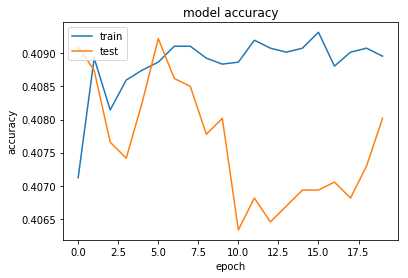

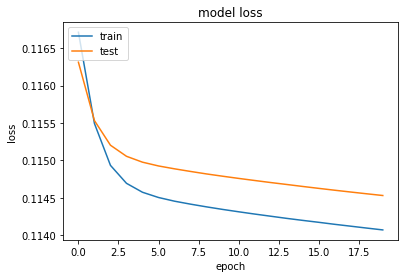

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
history = fit_results
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 10.2 Model Accuracy (Training & Validation)

In [93]:
scores = model.evaluate(x_train, y_train, verbose = 0)
print("Training Accuracy: %.2f%%" % (scores[1]*100))

Training Accuracy: 23.12%


In [94]:
scores = model.evaluate(x_val, y_val, verbose = 0)
print("Validation Accuracy: %.2f%%" % (scores[1]*100))

Validation Accuracy: 23.18%


# 11.0 Prediction from Validation

In [95]:
def predictOne():
    i_x = randint(0,len(x_val))
    print i_x
    tgt = x_val[i_x,0:10000]
    tgt = tgt.reshape(1,1000)
    tpr = model.predict(tgt)
    print(np.round(tpr,2))

In [99]:
predictOne()

2749
[[ 0.01        0.16        0.13        0.17        0.25        0.28999999]]


# 11.1 Prediction from User Input

In [100]:
def predictStmt(stmt):
    my_sequence = tokenizer.texts_to_sequences(stmt)
    my_data = pad_sequences(my_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    my_result = model.predict(my_data)
    print(np.round(my_result,2))

In [101]:
stmt = ["I have this petri net and I need to know if there is a path that follows this order for example: " +
            " (p2-p6-p12). I'm using this ltl: []-(p2/\(<>p6)/\(<>p12)) but the problem is that this doesn't " +
            " express the order that I need. How can I rearrange for my purpose?"]

In [103]:
stmt= ["I need to understand if the order of scores in the original frame will be maintained using " +
           " this approach. In particular, will the scores order be maintained through the the cast to a " + 
           " RDD followed with the collect?"]

In [1]:
stmt

NameError: name 'stmt' is not defined

In [104]:
predictStmt(stmt)

[[ 0.02        0.16        0.13        0.15000001  0.23        0.31      ]]
